# Authors:

Daniel Vila de la Cruz

Sara Gómez Feás

In [1]:
# Dataset path
from os import listdir
import os.path

#PATH = './datasets/faces_dataset_train/'
PATH = './datasets/faces_dataset_train/faces_dataset_train/'
PATH_TEST = './datasets/faces_dataset_test/faces_dataset_test/'

assert os.path.exists(PATH), 'Verify the above commands'
assert os.path.exists(PATH_TEST), 'Verify the above commands'

In [2]:
import json

with open(PATH + 'metadata.json') as fIn:
    metadata = json.loads(fIn.read())
with open(PATH_TEST + 'metadata.json') as fIn:
    metadata_test = json.loads(fIn.read())

metadata_example_key = next(iter(metadata.keys()))
metadata_example_value = metadata[metadata_example_key]

print(metadata_example_key, end=' ----> ')
print(metadata_example_value)

i07/nm0322407_rm852269056_1955-3-29_2005.jpg ----> {'age': 50, 'gender': 'M'}


In [3]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [4]:
import tensorflow as tf
from matplotlib import pyplot

# Size at which images will be processed
img_height = 32
img_width = 32

def decode_img(img):
    '''Transforms a string that represents the path of an image into a matrix
    (img_height, img_width, 3) of uint8 representing the pixel values
    '''
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_jpeg(img, channels=3)
    # Resize the image to the desired size.
    return tf.cast(tf.image.resize(img, [img_height, img_width]),tf.uint8)

# def process_path_age(file_path):
#     '''Transforma cadenas de la forma 'ruta|edad|genero' a tuplas (imagen, etiqueta)
#     '''
#     parts = tf.strings.split(file_path, '|')
#     age = parts[1]
#     age = tf.strings.to_number(age, out_type=tf.dtypes.int32)
#     gender = parts[2]
#     # Load the raw data from the file as a string
#     img = tf.io.read_file(parts[0])
#     img = decode_img(img)
#     return img, age

def process_path(file_path):
    '''Transforms strings of the form 'path|age|gender' to tuples (image, label)
    '''
    parts = tf.strings.split(file_path, '|')
    print(parts)
    gender = tf.cast(0 if parts[2] == 'M' else 1, tf.dtypes.int32)
    # Load the raw data from the file as a string
    img = tf.io.read_file(parts[0])
    img = decode_img(img)
    return img, gender

def format_metadata(m, path):
    '''Transforms the metadata dictionary m into a list of strings of the form 'path to the image|age|gender'.
    '''
    return list(map(lambda x: '{0}{1}|{2}|{3}'.format(path,x,m[x]['age'],m[x]['gender']),m.keys()))

# We build a dataset of text strings from the metadata
train_metadata = format_metadata(metadata, PATH)
train_ds = tf.data.Dataset.from_tensor_slices(train_metadata)
print(train_ds.take(1))

# Mapping to an image dataset with tags
train_ds = train_ds.shuffle(len(train_ds)).map(process_path)

# Same process for test
test_ds = tf.data.Dataset.from_tensor_slices(format_metadata(metadata_test, PATH_TEST))
test_ds = test_ds.map(process_path)


<TakeDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>
Tensor("StringSplit/RaggedGetItem/strided_slice_5:0", shape=(None,), dtype=string)
Tensor("StringSplit/RaggedGetItem/strided_slice_5:0", shape=(None,), dtype=string)


In [5]:
ds_train_transform = train_ds
ds_test_transform = test_ds
print(train_metadata[0])

./datasets/faces_dataset_train/faces_dataset_train/i07/nm0322407_rm852269056_1955-3-29_2005.jpg|50|M


# Preprocessing data

In [6]:
# Rescaling input to [-1, 1]
ds_train_transform = ds_train_transform.map(lambda image, label: (tf.cast(image, tf.float32)/127.5 - 1., label))
ds_test_transform = ds_test_transform.map(lambda image, label: (tf.cast(image, tf.float32)/127.5 - 1., label))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [7]:
# Sample gender weights
import numpy as np
labels = [0 if x.split('|')[2] == 'M' else 1 for x in train_metadata]
freqs = np.array([1. - np.mean(labels), np.mean(labels)])
i_freqs = 1. / freqs
sample_weights = tf.convert_to_tensor(len(i_freqs) * i_freqs / i_freqs.sum())
print(sample_weights)
ds_train_transform = ds_train_transform.map(lambda image, label: (image, label, sample_weights[label]))
ds_test_transform = ds_test_transform.map(lambda image, label: (image, label, sample_weights[label]))

tf.Tensor([0.8294171 1.1705829], shape=(2,), dtype=float64)


In [8]:
batch_size = 128
ds_train_batch = ds_train_transform.batch(batch_size)
ds_test_batch = ds_test_transform.batch(batch_size)

# CNN to predict the gender

In [11]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import layers

## Previous models

For the first approaches we used the models designed for the previous version of the notebook, which were using train data for validation as an error. Those models were simple and used few regularization techniques, so overfitting appeared at the first epochs of training, and there was also a drop in accuracy.

## First model

In order to achieve better results and avoid overfitting, we designed the following model. It takes as input images with a shape of 32x32 and 3 color channels and has three blocks of convolutional, max pooling and dropout layers for the feature learning section, and then a classification section:

* Feature learning: in the first block, we apply 3 convolutional layers with 32 filters, a kernel size of 3x3 and ReLU activation function. Then there is a max pooling layer with a pool size of 2x2 and a dropout layer with 0.25 rate. The second block has 2 convolutional layers with 64 filters and the same other settings, followed again by a max pooling and dropout layers. The last block only has one convolutional layer with 128 filters and the same max pooling and dropout layers.
* Classification: first a flatten layer is applied, followed by a dense layer with 128 neurons and ReLU as activation function. Then batch normalization is applied, ending with an output layer with one neuron and sigmoid activation function.

The explanation of the layers is the following:
* The convolutional layers are used to extract the features of the image.
* The max pooling layers are used to reduce the spatial dimenstions of the output of the convolutional layers.
* The dropout layers are used to reduce the overfitting, by randomly setting a fraction (0.25) of the input unit to 0 during training. We tried with less dropout layers and higher dropout rate, but it reduced the accuracy of the model.
* The flatten layer is used to flatten the output of the feature learning section into a vector.
* The dense layers are used to classify the output. The first one, with 128 neurons, can be also understood as a high-level feature extraction, weighing the most informative features. The second dense layer, with 1 neuron, is used to predict the probability of the input belonging to one of the two classes.


* Activation function ReLU is chosen to introduce non-linearity in the model.
* Activation function sigmoid is chosen to predict the probability of belonging to a specific class.

We also used early stopping and a learning rate of 0.0005 in order to avoid overfitting.


In [12]:
inputs = keras.Input(shape=(32, 32, 3), name="Input_layer")

x = layers.Conv2D(filters=32, kernel_size=3, activation="relu", name="Conv1")(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu", name="Conv2")(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu", name="Conv3")(x)
x = layers.MaxPooling2D(pool_size=2, name="Pool1")(x)
x = layers.Dropout(0.25)(x)

x = layers.Conv2D(filters=64, kernel_size=3, activation="relu",name="Conv4")(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu",name="Conv5")(x)
x = layers.MaxPooling2D(pool_size=2, name="Pool2")(x)
x = layers.Dropout(0.25)(x)

x = layers.Conv2D(filters=128, kernel_size=3, activation="relu",name="Conv7")(x)
x = layers.MaxPooling2D(pool_size=2, name="Pool3")(x)
x = layers.Dropout(0.25)(x)

x = layers.Flatten(name="Flatten_layer")(x)
x = layers.Dense(128, activation="relu", name="Dense1")(x)
x = layers.BatchNormalization()(x)
outputs = layers.Dense(1, activation="sigmoid", name="Output_layer")(x)
model = keras.Model(inputs=inputs, outputs=outputs, name="CNN")

model.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 32, 32, 3)]       0         
                                                                 
 Conv1 (Conv2D)              (None, 30, 30, 32)        896       
                                                                 
 Conv2 (Conv2D)              (None, 28, 28, 32)        9248      
                                                                 
 Conv3 (Conv2D)              (None, 26, 26, 32)        9248      
                                                                 
 Pool1 (MaxPooling2D)        (None, 13, 13, 32)        0         
                                                                 
 dropout_3 (Dropout)         (None, 13, 13, 32)        0         
                                                                 
 Conv4 (Conv2D)              (None, 11, 11, 64)        18496   

In [13]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=3)


# compile
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss="binary_crossentropy", metrics=["accuracy"], weighted_metrics=[])

# train
history=model.fit(ds_train_batch, epochs=25, batch_size=batch_size, validation_data=ds_test_batch, callbacks=[early_stopping])

Epoch 1/25
992/992 [==============================] - 401s 400ms/step - loss: 0.4406 - accuracy: 0.7905 - val_loss: 0.3630 - val_accuracy: 0.8390
Epoch 2/25
992/992 [==============================] - 358s 360ms/step - loss: 0.3408 - accuracy: 0.8585 - val_loss: 0.3411 - val_accuracy: 0.8650
Epoch 3/25
992/992 [==============================] - 347s 350ms/step - loss: 0.3196 - accuracy: 0.8689 - val_loss: 0.3541 - val_accuracy: 0.8330
Epoch 4/25
992/992 [==============================] - 345s 348ms/step - loss: 0.3081 - accuracy: 0.8758 - val_loss: 0.3377 - val_accuracy: 0.8570
Epoch 5/25
992/992 [==============================] - 351s 354ms/step - loss: 0.2976 - accuracy: 0.8818 - val_loss: 0.3556 - val_accuracy: 0.8430
Epoch 6/25
992/992 [==============================] - 347s 349ms/step - loss: 0.2927 - accuracy: 0.8836 - val_loss: 0.3248 - val_accuracy: 0.8720
Epoch 7/25
992/992 [==============================] - 349s 352ms/step - loss: 0.2864 - accuracy: 0.8866 - val_loss: 0.3482 -

In [14]:
model.save("model_dropout4.h5")

The accuracy plot shows that both the training and validation accuracies increase over time, indicating that the model is learning and performing well on both the training and validation data. There are some fluctuations on the firsts epochs of the validation, but it ends up stabilizing. The same occurs with the losses plot, but this time there is a slightly trend to increase at the end, so thanks to the early stopping we avoid to overfit the model.

<Figure size 640x480 with 0 Axes>

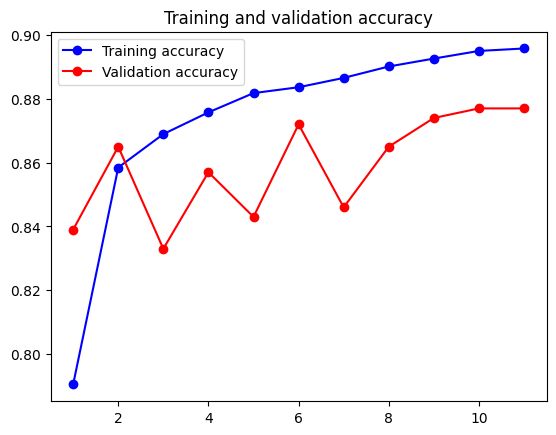

<Figure size 640x480 with 0 Axes>

In [15]:
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, "b-o", label="Training accuracy")
plt.plot(epochs, val_accuracy, "r-o", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()

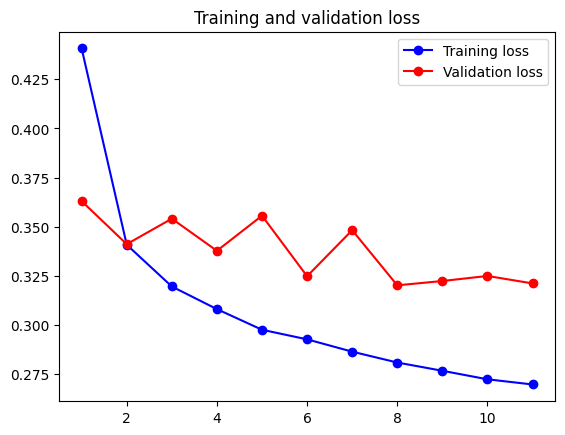

In [16]:
plt.plot(epochs, loss, "b-o", label="Training loss")
plt.plot(epochs, val_loss, "r-o", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

## Second model

For our next approach, we decided to incorporate L2 regularization in the Output layer of our model to prevent overfitting. Specifically, we added a kernel_regularizer parameter with a regularization factor of 0.01. This helps to prevent the model from relying too heavily on any one input feature, which can lead to better generalization performance. We kept the convolutional layers, pooling layers and dropout layers the same as in our previous model.

In [17]:
from tensorflow.keras import regularizers
inputs = keras.Input(shape=(32, 32, 3), name="Input_layer")

x = layers.Conv2D(filters=32, kernel_size=3, activation="relu", name="Conv1")(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu", name="Conv2")(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu", name="Conv3")(x)
x = layers.MaxPooling2D(pool_size=2, name="Pool1")(x)
x = layers.Dropout(0.25)(x)

x = layers.Conv2D(filters=64, kernel_size=3, activation="relu",name="Conv4")(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu",name="Conv5")(x)
x = layers.MaxPooling2D(pool_size=2, name="Pool2")(x)
x = layers.Dropout(0.25)(x)

x = layers.Conv2D(filters=128, kernel_size=3, activation="relu",name="Conv7")(x)
x = layers.MaxPooling2D(pool_size=2, name="Pool3")(x)
x = layers.Dropout(0.25)(x)

x = layers.Flatten(name="Flatten_layer")(x)
x = layers.Dense(128, activation="relu", name="Dense1")(x)
x = layers.BatchNormalization()(x)
outputs = layers.Dense(1, activation="sigmoid", kernel_regularizer=regularizers.l2(0.01), name="Output_layer")(x)
model = keras.Model(inputs=inputs, outputs=outputs, name="CNN")

model.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 32, 32, 3)]       0         
                                                                 
 Conv1 (Conv2D)              (None, 30, 30, 32)        896       
                                                                 
 Conv2 (Conv2D)              (None, 28, 28, 32)        9248      
                                                                 
 Conv3 (Conv2D)              (None, 26, 26, 32)        9248      
                                                                 
 Pool1 (MaxPooling2D)        (None, 13, 13, 32)        0         
                                                                 
 dropout_6 (Dropout)         (None, 13, 13, 32)        0         
                                                                 
 Conv4 (Conv2D)              (None, 11, 11, 64)        18496   

In [18]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=3)


# compile
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss="binary_crossentropy", metrics=["accuracy"], weighted_metrics=[])

# train
history=model.fit(ds_train_batch, epochs=25, batch_size=batch_size, validation_data=ds_test_batch, callbacks=[early_stopping])

Epoch 1/25
992/992 [==============================] - 403s 404ms/step - loss: 0.4459 - accuracy: 0.7917 - val_loss: 0.3932 - val_accuracy: 0.8080
Epoch 2/25
992/992 [==============================] - 373s 376ms/step - loss: 0.3412 - accuracy: 0.8594 - val_loss: 0.3536 - val_accuracy: 0.8550
Epoch 3/25
992/992 [==============================] - 383s 385ms/step - loss: 0.3172 - accuracy: 0.8726 - val_loss: 0.3492 - val_accuracy: 0.8630
Epoch 4/25
992/992 [==============================] - 379s 382ms/step - loss: 0.3047 - accuracy: 0.8789 - val_loss: 0.3709 - val_accuracy: 0.8350
Epoch 5/25
992/992 [==============================] - 381s 384ms/step - loss: 0.2966 - accuracy: 0.8828 - val_loss: 0.3497 - val_accuracy: 0.8730
Epoch 6/25
992/992 [==============================] - 471s 475ms/step - loss: 0.2906 - accuracy: 0.8864 - val_loss: 0.3177 - val_accuracy: 0.8800
Epoch 7/25
992/992 [==============================] - 496s 498ms/step - loss: 0.2845 - accuracy: 0.8895 - val_loss: 0.3282 -

In [19]:
model.save("model_l2.h5")

<Figure size 640x480 with 0 Axes>

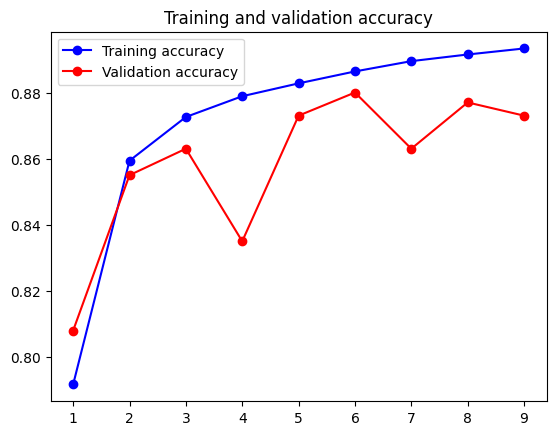

<Figure size 640x480 with 0 Axes>

In [20]:
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, "b-o", label="Training accuracy")
plt.plot(epochs, val_accuracy, "r-o", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()

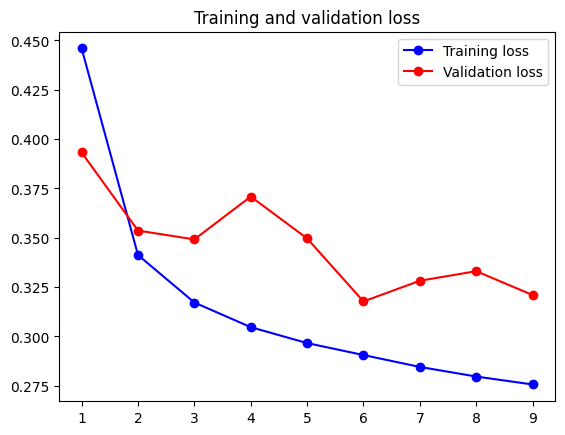

In [21]:
plt.plot(epochs, loss, "b-o", label="Training loss")
plt.plot(epochs, val_loss, "r-o", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

# Conclusions

After experimenting with different approaches, we have found that the first approach, using the models designed for the previous wrong notebook, lead to way worse results. The other two models achieve similar results, validation accuracy around 0.88 and a loss of 0.32, values that we consider as a nice solution, taking into account the low resolution of the input images (32x32).

It is possible that further experimentation and hyperparameter tuning could improve the performance of the models, as well as evaluating the model on a test set so we can get a more accurate estimate of how well the model will perform on new unseen data in the future. This would helps us to better compare the different models and choose the one that performs the best on the test set.

Also, increasing the resolution of the images may lead to better results, but at the cost of way higher time consumption to train the models.